# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    MinMaxScaler, StandardScaler, PolynomialFeatures
)

from sklearn.datasets import load_digits, fetch_20newsgroups
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfTransformer, TfidfVectorizer
)

In [2]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
# Funcoes para auxiliar na analise de dataset
from IPython.display import display

def missing_data(df):    
    missing_data = pd.DataFrame({'Tipo': df.dtypes,'Dados faltantes (%)': df.isna().sum() / df.shape[0]})
    return missing_data

def sumary_df(df):
    print("Informações básicas do dataset")
    print("\nFormato:", df.shape)
    display(df.head(5))
    
    print("\nTipos de dados:")
    display(df.info())

    print("\nPercentual de dados faltantes:")
    display(missing_data(df).T)

    print("\nEstatísticas das features:")
    display(df.describe())
    
def converte_float(num, casas_decimais):
    aux = np.float32(round(num, casas_decimais))
    num_float = round(aux.item(), casas_decimais)
    return num_float

In [4]:
countries = pd.read_csv("countries.csv")

In [5]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

## Inicia sua análise a partir daqui

In [6]:
# Ajustando dados antes de iniciar analise
df = countries

# Lista de variaveis com (,) ao inves de (.)
column_replace = ['Pop_density', 'Coastline_ratio', 'Net_migration', 'Infant_mortality', 'Literacy', 'Phones_per_1000',
                 'Arable', 'Crops', 'Other', 'Climate','Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service']

# Convertendo colunas para tipo numerico
for i in column_replace:
    df.loc[:, i] = df.loc[:, i].str.replace(',', '.')
    df.loc[:, i] = df.loc[:, i].astype(float)


# Ajustando espacos nas colunas
df['Country'] = df['Country'].str.strip()
df['Region'] = df['Region'].str.strip()

In [7]:
sumary_df(df)

Informações básicas do dataset

Formato: (227, 20)


,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN



Tipos de dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
Country             227 non-null object
Region              227 non-null object
Population          227 non-null int64
Area                227 non-null int64
Pop_density         227 non-null float64
Coastline_ratio     227 non-null float64
Net_migration       224 non-null float64
Infant_mortality    224 non-null float64
GDP                 226 non-null float64
Literacy            209 non-null float64
Phones_per_1000     223 non-null float64
Arable              225 non-null float64
Crops               225 non-null float64
Other               225 non-null float64
Climate             205 non-null float64
Birthrate           224 non-null float64
Deathrate           223 non-null float64
Agriculture         212 non-null float64
Industry            211 non-null float64
Service             212 non-null float64
dtypes: float64(16), int64(2), object(2)
memory usage: 35.5+ KB


None


Percentual de dados faltantes:


,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
Tipo,object,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Dados faltantes (%),0,0,0,0,0,0,0.0132159,0.0132159,0.00440529,0.0792952,0.0176211,0.00881057,0.00881057,0.00881057,0.0969163,0.0132159,0.0176211,0.0660793,0.0704846,0.0660793



Estatísticas das features:


,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
count,2.270000e+02,2.270000e+02,227.000000,227.000000,224.000000,224.000000,226.000000,209.000000,223.000000,225.000000,225.000000,225.000000,205.000000,224.000000,223.000000,212.000000,211.000000,212.000000
mean,2.874028e+07,5.982270e+05,379.047137,21.165330,0.038125,35.506964,9689.823009,82.838278,236.061435,13.797111,4.564222,81.638311,2.139024,22.114732,9.241345,0.150844,0.282711,0.565283
std,1.178913e+08,1.790282e+06,1660.185825,72.286863,4.889269,35.389899,10049.138513,19.722173,227.991829,13.040402,8.361470,16.140835,0.699397,11.176716,4.990026,0.146798,0.138272,0.165841
min,7.026000e+03,2.000000e+00,0.000000,0.000000,-20.990000,2.290000,500.000000,17.600000,0.200000,0.000000,0.000000,33.330000,1.000000,7.290000,2.290000,0.000000,0.020000,0.062000
25%,4.376240e+05,4.647500e+03,29.150000,0.100000,-0.927500,8.150000,1900.000000,70.600000,37.800000,3.220000,0.190000,71.650000,2.000000,12.672500,5.910000,0.037750,0.193000,0.429250
50%,4.786994e+06,8.660000e+04,78.800000,0.730000,0.000000,21.000000,5550.000000,92.500000,176.200000,10.420000,1.030000,85.700000,2.000000,18.790000,7.840000,0.099000,0.272000,0.571000
75%,1.749777e+07,4.418110e+05,190.150000,10.345000,0.997500,55.705000,15700.000000,98.000000,389.650000,20.000000,4.440000,95.440000,3.000000,29.820000,10.605000,0.221000,0.341000,0.678500
max,1.313974e+09,1.707520e+07,16271.500000,870.660000,23.060000,191.190000,55100.000000,100.000000,1035.600000,62.110000,50.680000,100.000000,4.000000,50.730000,29.740000,0.769000,0.906000,0.954000


## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [8]:
def q1():
    unique_region = df['Region'].unique().tolist()
    unique_region.sort()
    return unique_region

In [9]:
print("Resposta questão 1:\n", q1())

Resposta questão 1:
 ['ASIA (EX. NEAR EAST)', 'BALTICS', 'C.W. OF IND. STATES', 'EASTERN EUROPE', 'LATIN AMER. & CARIB', 'NEAR EAST', 'NORTHERN AFRICA', 'NORTHERN AMERICA', 'OCEANIA', 'SUB-SAHARAN AFRICA', 'WESTERN EUROPE']


## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [10]:
def q2():
    # Retorne aqui o resultado da questão 2.
    discretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
    discretizer.fit(df[['Pop_density']])

    score_bins = discretizer.transform(df[['Pop_density']])
    resp = (score_bins>=9).sum()
    return int(resp)

In [11]:
print("Resposta questão 2:", q2())

Resposta questão 2: 23


## Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [12]:
def q3():
    one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int)

    region_onehot = one_hot_encoder.fit_transform(df[["Region"]])
    climate_onehot = one_hot_encoder.fit_transform(df[["Climate"]].fillna(0))

    return region_onehot.shape[1] + climate_onehot.shape[1]

In [13]:
print("Resposta questão 3: ", q3())

Resposta questão 3:  18


## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [14]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

In [15]:
def q4():
    pipeline_q4 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("padronizacao", StandardScaler())
        ])

    pipeline_transformation = pipeline_q4.fit_transform(df.loc[:, 'Population': 'Service'])
    
    resp = pipeline_q4.transform([test_country[2:]])
    return converte_float(resp[0,9], 3)

In [16]:
print("Reposta questão 4:", q4())

Reposta questão 4: -1.047


## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

In [17]:
def q5():
    q1 = df['Net_migration'].quantile(0.25)
    q3 = df['Net_migration'].quantile(0.75)
    iqr = q3 - q1
    
    outliers_abaixo = (df['Net_migration'] < (q1 - (1.5*iqr))).sum()
    outliers_acima =  (df['Net_migration'] > (q3 + (1.5*iqr))).sum()
    
    return(int(outliers_abaixo), int(outliers_acima), False)

In [18]:
print("Resposta questão 5:", q5())

Resposta questão 5: (24, 26, False)


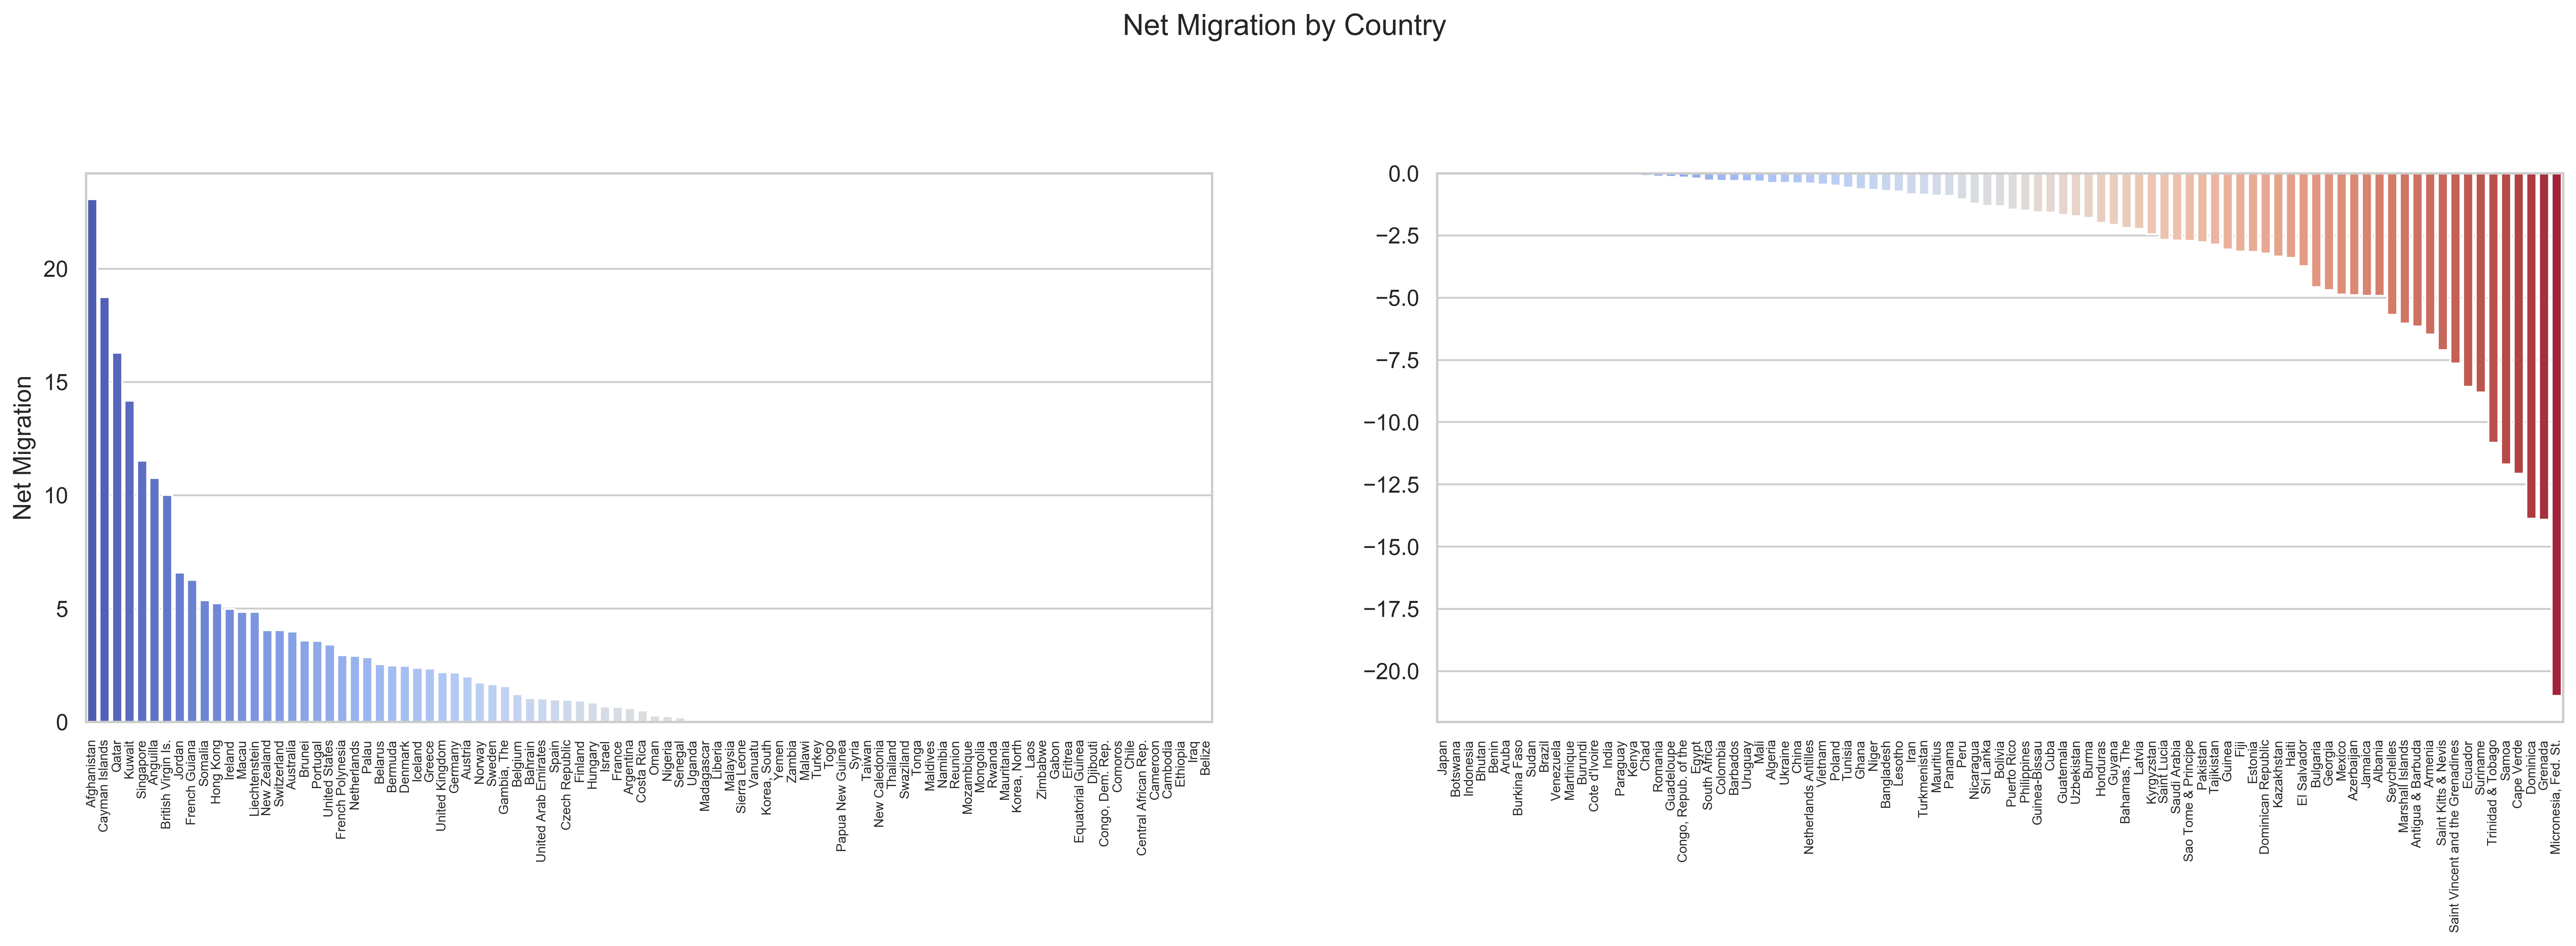

In [63]:
# Sorting values
df_sort_net = df.sort_values('Net_migration', ascending=False).dropna()
half = round(df_sort_net.shape[0]/2)

# Plotting figure
fig, axes = plt.subplots(1, 2, figsize=(24, 12), dpi= 400, facecolor='w', edgecolor='k')
sns.set_style('whitegrid')
plt.suptitle("Net Migration by Country")

plt.subplot(221)
b_plot  = sns.barplot(x="Country", y="Net_migration", data=df_sort_net.iloc[0:half, :], palette="coolwarm")
b_plot.set_xticklabels(b_plot.get_xticklabels(), rotation=90, fontsize=7)
b_plot.set_xlabel("")
b_plot.set_ylabel("Net Migration")

plt.subplot(222)
b_plot  = sns.barplot(x="Country", y="Net_migration", data=df_sort_net.iloc[half:, :], palette="coolwarm")
b_plot.set_xticklabels(b_plot.get_xticklabels(), rotation=90, fontsize=7)
b_plot.set_xlabel("")
b_plot.set_ylabel("")


plt.show()

O gráfico acima demonstra que como a migração ocorre entre os países, é possível observa a mesma faixa de valores em cada um dos extremos do gráfico, portanto os dados considerados como outliers na questão devem ser mantidos. Pode-se chegar a uma conclusão simular analisando o boxplot abaixo:

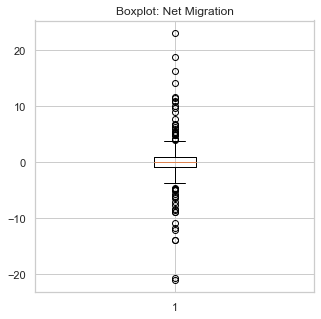

In [22]:
figsize(5, 5)
sns.set_style('whitegrid')
plt.title("Boxplot: Net Migration")
plt.boxplot(df['Net_migration'].dropna())
plt.show()

Como observado pelo

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [64]:
# Loading dataset
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)

In [65]:
count_vectorizer = CountVectorizer()
newsgroups_counts = count_vectorizer.fit_transform(newsgroup.data)
words_idx = sorted([count_vectorizer.vocabulary_.get(f"{word.lower()}") for word in [u"phone"]])

In [66]:
def q6():
    df_phone = pd.DataFrame(newsgroups_counts[:, words_idx].toarray(), 
                            columns=np.array(count_vectorizer.get_feature_names())[words_idx])

    return int(df_phone.sum())

In [67]:
print("Resposta questão 6:", q6())

Resposta questão 6: 213


## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [68]:
def q7():
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(newsgroup.data)

    newsgroups_tfidf_vectorized = tfidf_vectorizer.transform(newsgroup.data)

    result = pd.DataFrame(newsgroups_tfidf_vectorized[:, words_idx].toarray(), 
                          columns=np.array(count_vectorizer.get_feature_names())[words_idx])

    return converte_float(result.sum(), 3)

In [69]:
print("Resposta questão 7:", q7())

Resposta questão 7: 8.888
